# COS711-A2
_This notebook was created using Kaggle_

## Introduction

This project involves developing a neural network (NN) to classify almonds into three different types based on numeric features extracted from their images. The dataset contains a variety of almond samples, with the purpose of accurately categorising them using machine learning techniques. To accomplish this, the following steps are necessary:

1. **Data Preprocessing**: Clean and prepare the dataset for optimal results during training.
2. **Hyperparameter Optimisation**: Fine-tune the neural network's hyperparameters to improve classification accuracy.
3. **A Comparative Study of Gradient-Based Algorithms**: Evaluate the performance of several gradient-based optimisation strategies to determine the most effective strategy for training the NN.
4. **Hybrid Training Algorithm**: Create a new algorithm that uses gradient information from other optimisation approaches to increase convergence and performance.

The project's goal with these steps is to create a strong classification model while also investigating advanced training approaches.

# Imports
Import necessary packages.

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import time
import sys
import os
from scipy.stats import zscore, iqr, ttest_ind
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import RobustScaler, OneHotEncoder
from sklearn.metrics import accuracy_score
from sklearn.utils import shuffle
from sklearn.model_selection import train_test_split
import torch
import torch.nn as nn
import torch.optim as optim
import copy
from sklearn.model_selection import KFold
from torch.utils.data import DataLoader, TensorDataset

# Data Pre-processing

In [2]:
# Load the data
# data = pd.read_csv("./data/Almond.csv")
data = pd.read_csv("/kaggle/input/almond-types-classification/Almond.csv")
df = pd.DataFrame(data)

In [3]:
df.head()

,Unnamed: 0,Length (major axis),Width (minor axis),Thickness (depth),Area,Perimeter,Roundness,Solidity,Compactness,Aspect Ratio,Eccentricity,Extent,Convex hull(convex area),Type
0,0,NaN,227.940628,127.759132,22619.0,643.813269,NaN,0.973384,1.458265,NaN,NaN,0.681193,23237.5,MAMRA
1,1,NaN,234.188126,128.199509,23038.0,680.984841,NaN,0.957304,1.601844,NaN,NaN,0.656353,24065.5,MAMRA
2,2,NaN,229.418610,125.796547,22386.5,646.943212,NaN,0.967270,1.487772,NaN,NaN,0.683620,23144.0,MAMRA
3,3,NaN,232.763153,125.918808,22578.5,661.227483,NaN,0.965512,1.540979,NaN,NaN,0.685360,23385.0,MAMRA
4,4,NaN,230.150742,107.253448,19068.0,624.842706,NaN,0.951450,1.629395,NaN,NaN,0.714800,20041.0,MAMRA


In [4]:
df.drop(columns=['Unnamed: 0'], inplace=True)

In [5]:
df.describe()

,Length (major axis),Width (minor axis),Thickness (depth),Area,Perimeter,Roundness,Solidity,Compactness,Aspect Ratio,Eccentricity,Extent,Convex hull(convex area)
count,1946.000000,1861.000000,1799.000000,2803.000000,2803.000000,1946.000000,2803.000000,2803.000000,1004.000000,1004.000000,2803.000000,2803.000000
mean,290.609274,171.025915,109.705378,26511.117374,743.863770,0.470466,0.955828,1.825233,1.753216,0.813114,0.724587,27696.218159
std,62.719433,29.916529,18.940597,13782.561344,230.632076,0.118673,0.039596,0.794058,0.206616,0.041312,0.047474,14237.347610
min,151.335266,88.050529,59.494278,6037.000000,311.563489,0.173748,0.718772,1.164469,1.400082,0.699897,0.454538,6355.000000
25%,245.966293,149.453659,97.091682,16211.500000,571.730009,0.384810,0.944579,1.357398,1.612490,0.784476,0.701673,17088.500000
50%,279.879883,170.168365,110.280136,23440.500000,707.487369,0.472718,0.970422,1.576412,1.705716,0.810120,0.733720,24589.000000
75%,330.508575,190.640427,121.392773,33451.000000,878.896530,0.577553,0.981484,1.965953,1.833339,0.838141,0.757551,34863.250000
max,515.352478,258.569794,181.845200,89282.000000,1864.947387,0.697293,0.992889,9.660057,2.731251,0.930563,0.845813,90642.500000


In [6]:
# Displaying the data types
print(f'Data types:\n{df.dtypes}\n')

# Displaying missing values
print(f'Missing values:\n{df.isnull().sum()}\n')

Data types:
Length (major axis)         float64
Width (minor axis)          float64
Thickness (depth)           float64
Area                        float64
Perimeter                   float64
Roundness                   float64
Solidity                    float64
Compactness                 float64
Aspect Ratio                float64
Eccentricity                float64
Extent                      float64
Convex hull(convex area)    float64
Type                         object
dtype: object

Missing values:
Length (major axis)          857
Width (minor axis)           942
Thickness (depth)           1004
Area                           0
Perimeter                      0
Roundness                    857
Solidity                       0
Compactness                    0
Aspect Ratio                1799
Eccentricity                1799
Extent                         0
Convex hull(convex area)       0
Type                           0
dtype: int64



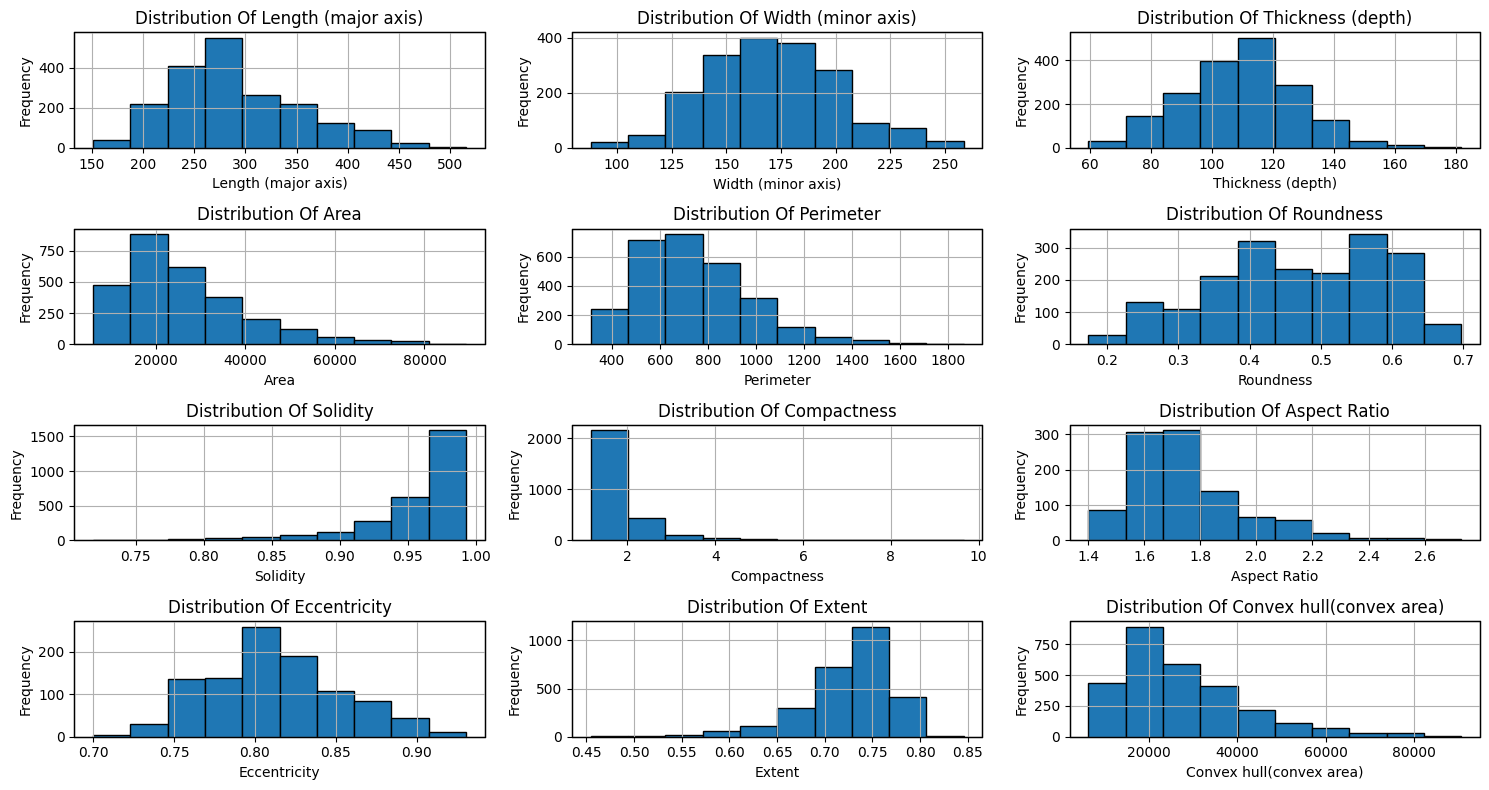

In [7]:
# View distributions for features
def visualise_distributions(df):
    if 'Type' in df.columns:
        features = df.drop(columns=['Type'])
    else:
        features = df

    # Number of features
    num_features = len(features.columns)

    # Determine grid size for subplots
    n_rows = (num_features + 2) // 3

    # Create a figure and a grid of subplots
    fig, axes = plt.subplots(n_rows, 3, figsize=(15, 8))
    axes = axes.flatten()

    # Plot each feature in a subplot
    for i, col in enumerate(features.columns):
        axes[i].hist(features[col], edgecolor='black')
        initial_col = col

        axes[i].set_title(f'Distribution Of {col}')

        axes[i].set_xlabel(col)
        axes[i].set_ylabel('Frequency')
        axes[i].grid()
        axes[i].patch.set_edgecolor('black')
        axes[i].patch.set_linewidth(1)

    # Remove any empty subplots
    for j in range(i + 1, len(axes)):
        fig.delaxes(axes[j])

    # Adjust layout
    plt.tight_layout()
    plt.show()

visualise_distributions(df)

In [8]:
len(df['Width (minor axis)'].isnull())

2803

In [9]:
len(df['Length (major axis)'].isnull())

2803

In [10]:
len(df[df['Length (major axis)'].isnull() & df['Width (minor axis)'].isnull()])

0

Notice that `Length (major axis)` and `Width (minor axis)` will never have the case where both are missing. Hence, when we impute one, we can immediately get their `Aspect Ratio` and `Eccentricity`.

In [11]:
len(df[df['Length (major axis)'].isnull() & df['Aspect Ratio'].isnull() & df['Eccentricity'].isnull()])

857

In [12]:
len(df[df['Width (minor axis)'].isnull() & df['Aspect Ratio'].isnull() & df['Eccentricity'].isnull()])

942

#### Analysis:

From the analysis above we can clearly see that both `Aspect ratio` and `Eccentricity` have missing values when either `Width (minor axis)` or `Length (major axis)` have missing values. Hence, we cannot make use of the formulas for `Aspect Ratio` or `Eccentricity` to find the actual values for those missing values.

Based on the distributions of the columns that contain missing values, most have a normal/near-normal distribution. We can, as a possible option, make use of mean imputation to handle missing values in those features. However, the distributions for `Length (major axis)` and `Aspect Ratio` are skewed to the right. Hence, we can potentially make use of median imputation for those features.

# Handle Outliers

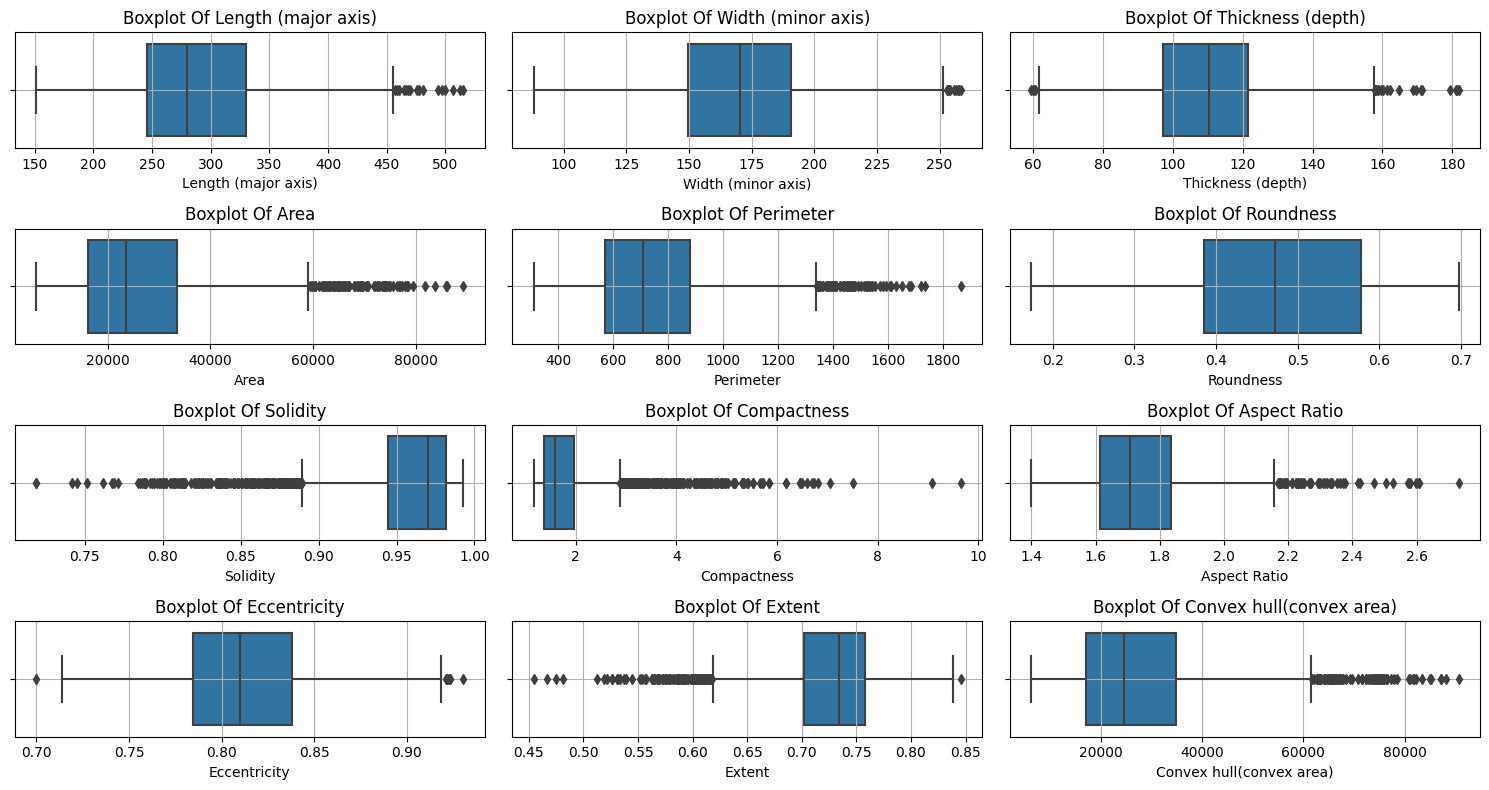

In [13]:
# visualise outliers
def visualise_outliers(df):
    if 'Type' in df.columns:
        features = df.drop(columns=['Type'])
    else:
        features = df

    # Number of features
    num_features = len(features.columns)

    # Determine grid size for subplots
    n_rows = (num_features + 2) // 3

    # Create a figure and a grid of subplots
    fig, axes = plt.subplots(n_rows, 3, figsize=(15, 8))
    axes = axes.flatten()

    # Plot each feature in a subplot
    for i, col in enumerate(features.columns):
        sns.boxplot(data=features, x=col, ax=axes[i])
        initial_col = col

        axes[i].set_title(f'Boxplot Of {col}')
        axes[i].grid()

    # Remove any empty subplots
    for j in range(i + 1, len(axes)):
        fig.delaxes(axes[j])

    # Adjust layout
    plt.tight_layout()
    plt.show()

visualise_outliers(df)

The data seems to contain a lot of outliers. For the normally/near-normally distributed features we will make use of z-scores to identify the outliers in those features and impute them with the mean value of that feature. As for the other features that have skewed distributions, we will identify outliers using Interquartile Range (IQR). These outliers will be imputed using the feature's median value.

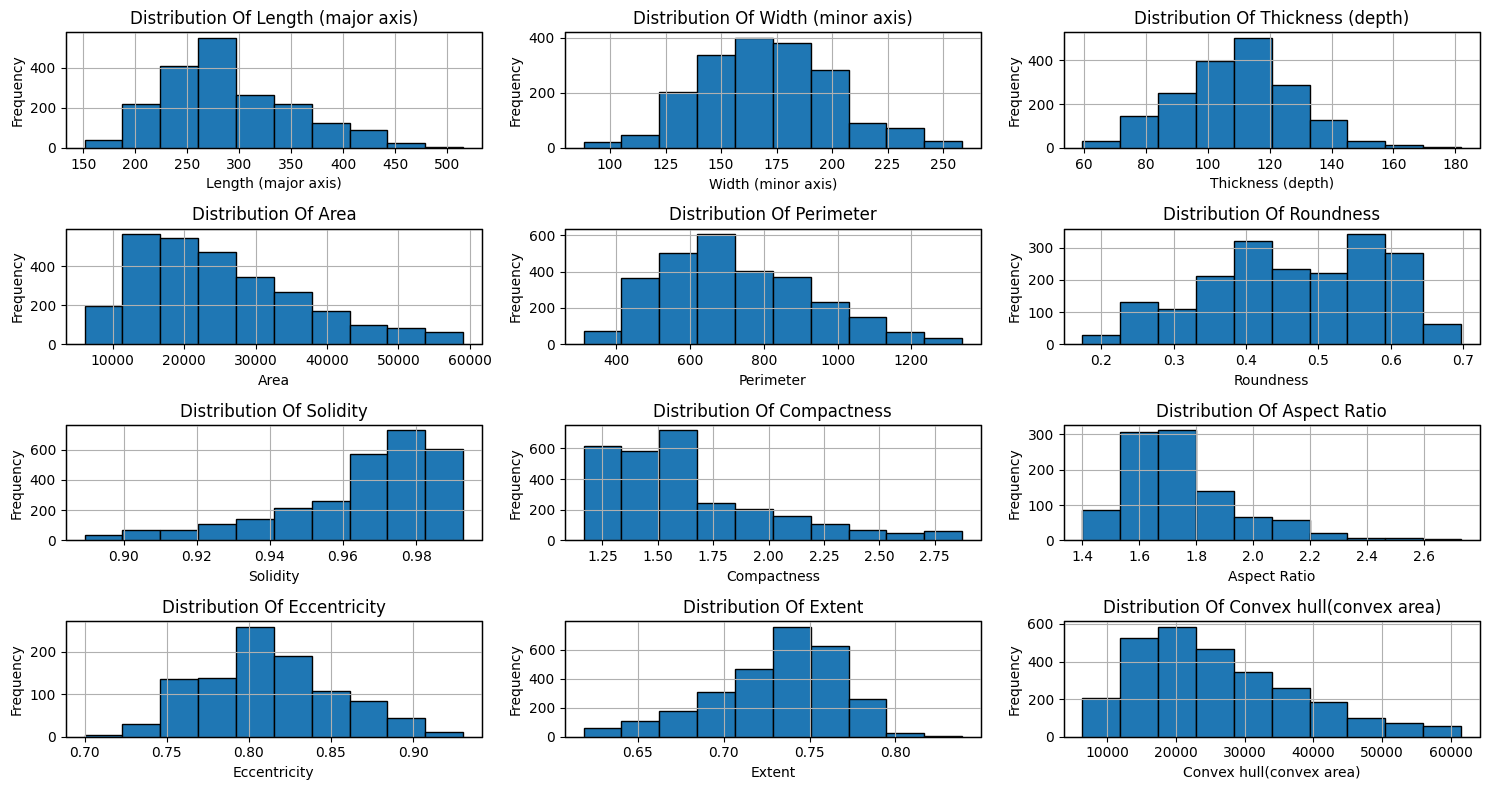

In [14]:
# Calculate Z-scores for each column
normally_columns = ['Width (minor axis)', 'Thickness (depth)', 'Roundness', 'Eccentricity']
skewed_columns = df.columns[~df.columns.isin(normally_columns) & ~df.columns.isin(['Type'])]
z_scores = zscore(df[normally_columns])

# Calculate absolute Z-scores
abs_z_scores = np.abs(z_scores)
threshold = 3

# Identify outliers
z_outliers = (abs_z_scores > threshold).any(axis=1)

# Impute outliers with mean (these follow normal/near-normal distribution)
df.loc[z_outliers, normally_columns] = df.loc[~z_outliers, normally_columns].mean()

# Calculate IQR for skew distributions
for col in skewed_columns:
    # Identify outliers
    q1 = df[col].quantile(0.25)
    q3 = df[col].quantile(0.75)
    iqr_value = iqr(df[col])
    lower_bound = q1 - 1.5 * iqr_value
    upper_bound = q3 + 1.5 * iqr_value

    # Impute outliers
    df.loc[(df[col] < lower_bound) | (df[col] > upper_bound), col] = df[col].median()

visualise_distributions(df)

## Handle missing values

**Choice on using KNN-imputation over mean/median:**

At first it was considered to impute missing values using mean/median imputation for the features `'Width (minor axis)'`, `'Length (major axis)'`, and `'Thickness (depth)'`. However, this resulted in the distributions of the updated features to introduce bias where the mean or median values formed the majority. To prevent this, the imputation strategy changed from using either mean or median imputation, to using a K-Nearest-Neighbour approach. This approach imputed the missing values using the `5` nearest neighbouring data points of a missing value in each feature, respectively. This approached has shown to be a better choice as the distributions now show unbiased values. This is only with respect to the three mentioned features.

In [15]:
# using KNN for imputations
from sklearn.impute import KNNImputer

# Create an instance of KNNImputer
imputer = KNNImputer(n_neighbors=5)

# Convert df to array-like shape
columns_to_impute = ['Width (minor axis)', 'Length (major axis)', 'Thickness (depth)']

df_as_array = df[columns_to_impute].values

# Impute missing values
df_imputed = imputer.fit_transform(df_as_array)

df_imputed = pd.DataFrame(df_imputed, columns=columns_to_impute)

df.update(df_imputed)

df.isnull().sum()

Length (major axis)            0
Width (minor axis)             0
Thickness (depth)              0
Area                           0
Perimeter                      0
Roundness                    857
Solidity                       0
Compactness                    0
Aspect Ratio                1799
Eccentricity                1799
Extent                         0
Convex hull(convex area)       0
Type                           0
dtype: int64

Notice that I did not replace the missing values for `Roundness`, `Eccentricity` or `Aspect Ratio`, even though I could have done the same as with the other features. The reason I choose not to replace them, is because these values are dependent on either/both `Length (major axis)` and `Width (minor axis)`. Therefore, I can make use of their respective formulas to calculate each missing value more accurate, instead of just using the mean or median imputations.

Missing values:
Length (major axis)         0
Width (minor axis)          0
Thickness (depth)           0
Area                        0
Perimeter                   0
Roundness                   0
Solidity                    0
Compactness                 0
Aspect Ratio                0
Eccentricity                0
Extent                      0
Convex hull(convex area)    0
Type                        0
dtype: int64



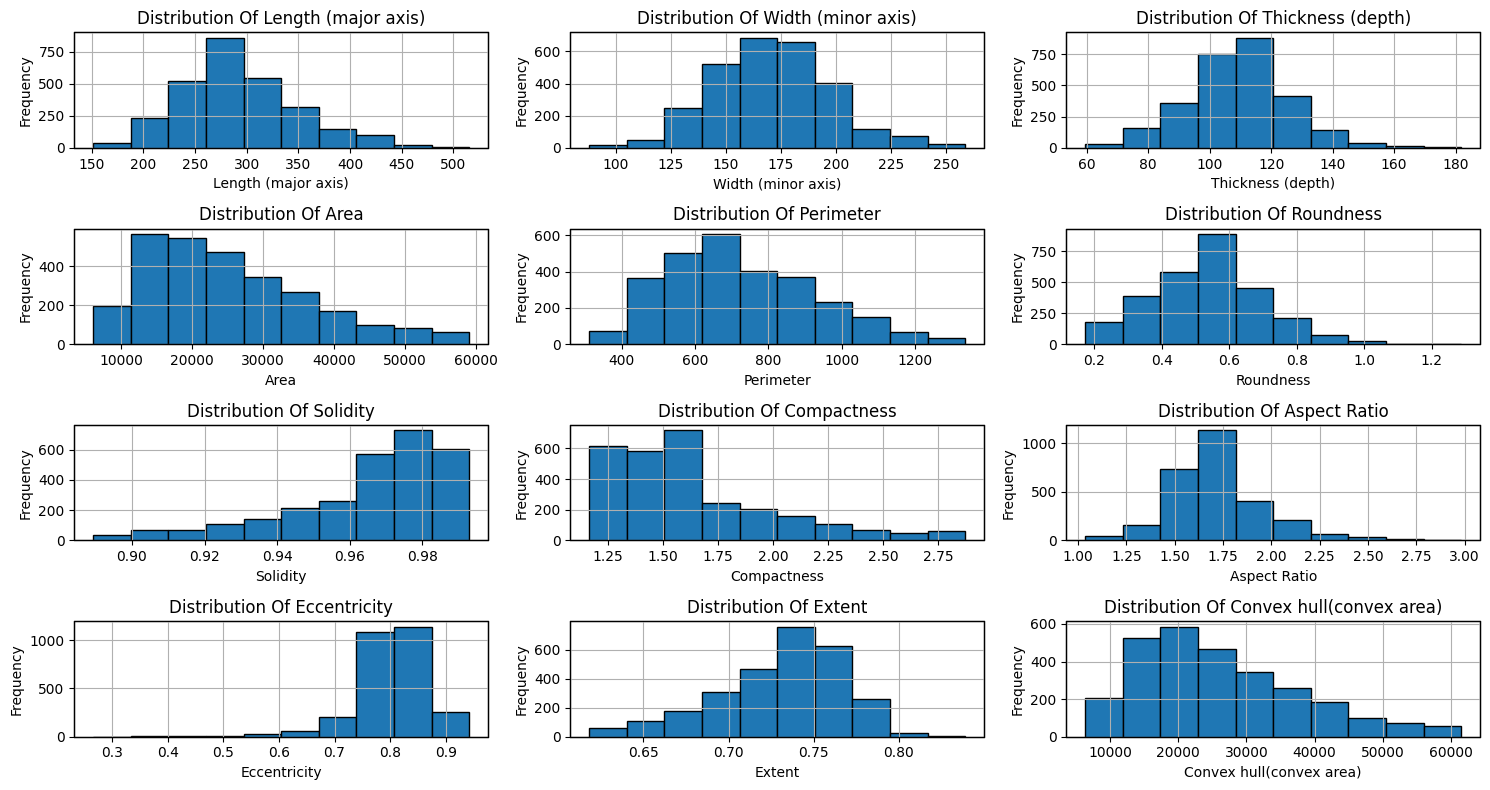

In [16]:
cleaned_df = df.copy()

cleaned_df['Eccentricity'] = cleaned_df['Eccentricity'].fillna(np.sqrt(1 - (cleaned_df['Width (minor axis)'] / cleaned_df['Length (major axis)']) ** 2))
cleaned_df['Aspect Ratio'] = cleaned_df['Aspect Ratio'].fillna(cleaned_df['Length (major axis)'] / cleaned_df['Width (minor axis)'])

# 'Roundess' makes use of the 'Area' and 'Length' and we've already handled 'Length'
# Thus we can make use of the formula to calculate 'Roundess'
cleaned_df['Roundness'] = cleaned_df['Roundness'].fillna((4 * np.pi * cleaned_df['Area']) / (np.pi * cleaned_df['Length (major axis)'] ** 2))

# Check if there are any missing values left
print(f'Missing values:\n{cleaned_df.isnull().sum()}\n')
visualise_distributions(cleaned_df)

## Standardising the data

- **Robust scaling:** We use the RobustScaler to scale the numerical features. Since there seems to be some existens of outliers (after handling missing values), the outliers might introduce some bias to the classification model. Min-max scaling is also deemed to sensitive to outliers and may lose important information when scaling to a range of `[0,1]`. As for standard scaling, it is also sensitive to outliers and assumes the data has a normal distribution, which is not the case here. Hence, robust scaling is used.

In [17]:
# Using robust scaling for numerical features
scaler = RobustScaler()
scaled_features = scaler.fit_transform(cleaned_df.drop(columns=['Type']))
scaled_features = pd.DataFrame(scaled_features, columns=cleaned_df.columns[:-1])

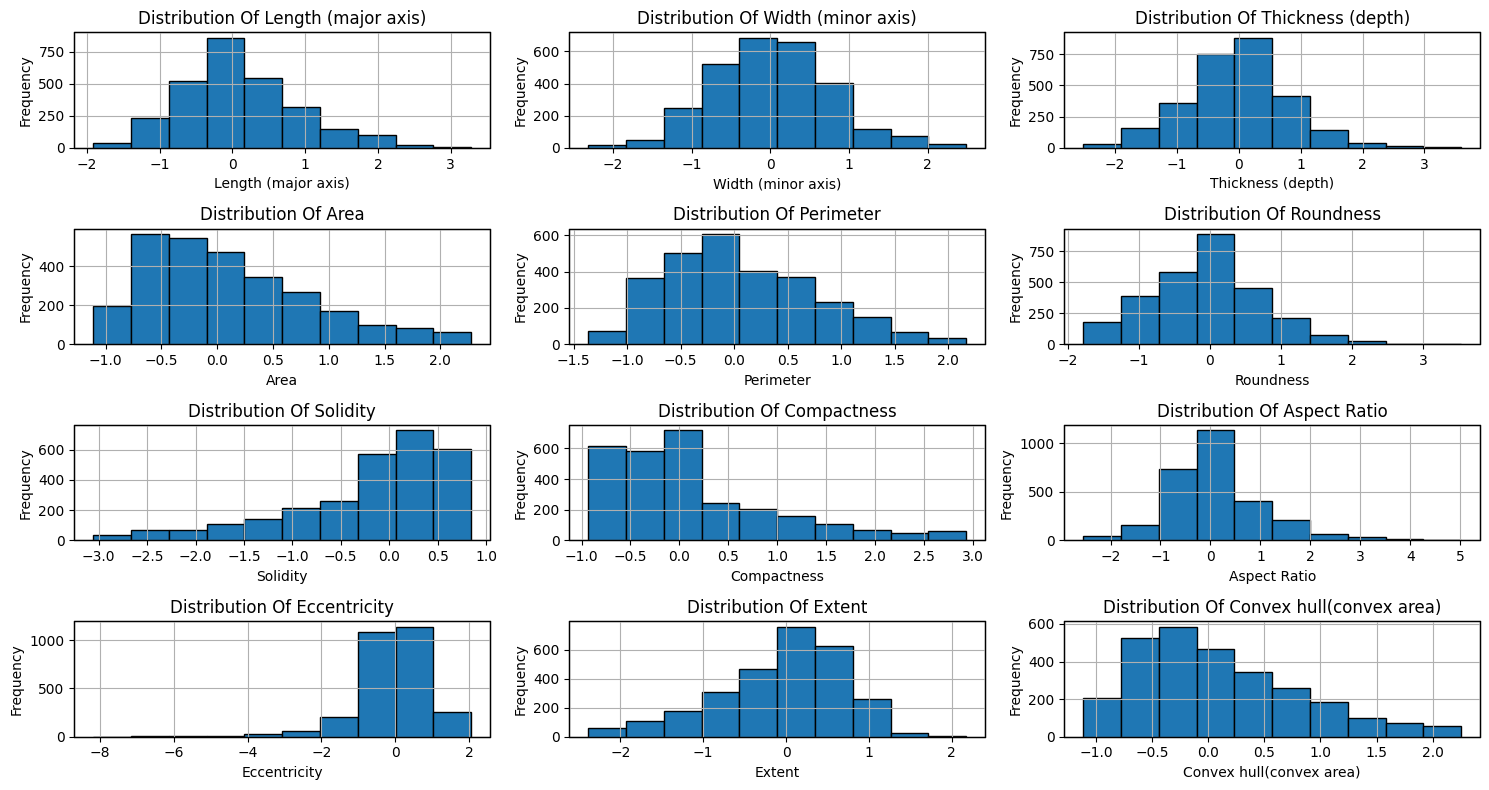

In [18]:
# Visualise new distributions
visualise_distributions(scaled_features)

In [19]:
scaled_features.describe()

,Length (major axis),Width (minor axis),Thickness (depth),Area,Perimeter,Roundness,Solidity,Compactness,Aspect Ratio,Eccentricity,Extent,Convex hull(convex area)
count,2803.000000,2803.000000,2803.000000,2803.000000,2803.000000,2803.000000,2803.000000,2803.000000,2803.000000,2803.000000,2803.000000,2803.000000
mean,0.101262,0.015262,-0.021232,0.105486,0.067297,-0.042518,-0.199514,0.143627,0.109749,-0.124744,-0.065574,0.099011
std,0.806771,0.755237,0.832826,0.729179,0.695448,0.766593,0.835955,0.833666,0.950192,1.038534,0.765260,0.718787
min,-1.912603,-2.312434,-2.511597,-1.111406,-1.361958,-1.781110,-3.055579,-0.931139,-2.545288,-8.171811,-2.388058,-1.113051
25%,-0.432754,-0.503782,-0.530124,-0.461651,-0.466998,-0.607139,-0.583286,-0.495050,-0.477710,-0.544753,-0.507646,-0.457850
50%,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
75%,0.567246,0.496218,0.469876,0.538349,0.533002,0.392861,0.416714,0.504950,0.522290,0.455247,0.492354,0.542150
max,3.280573,2.488363,3.592232,2.275465,2.166441,3.535261,0.846361,2.933197,5.017085,2.047656,2.174497,2.253296


## Encoding the data


In [20]:
# Using indices to encode types
encoder = cleaned_df.copy()
encoder['Type'] = encoder['Type'].astype('category')
encoder['Type'] = encoder['Type'].cat.codes
encoder = encoder.drop(columns=encoder.columns[:-1])

## Shuffling the data
Shuffling with Scikit-learn.

In [21]:
combined_cleaned_df = pd.concat([pd.DataFrame(scaled_features), encoder], axis=1)
print(combined_cleaned_df.head())

# Combine the data
X = combined_cleaned_df.iloc[:, :-1]
y = combined_cleaned_df.iloc[:, -1:]

# Shuffle
X, y = shuffle(X, y, random_state=99)

   Length (major axis)  Width (minor axis)  Thickness (depth)      Area  \
0             0.092051            1.626030           0.893992 -0.052462   
1             0.581326            1.801922           0.915962 -0.025704   
2             1.185487            1.667641           0.796083 -0.067310   
3             1.230732            1.761803           0.802182 -0.055048   
4             0.540405            1.688253          -0.128993 -0.279232   

   Perimeter  Roundness  Solidity  Compactness  Aspect Ratio  Eccentricity  \
0  -0.219036   2.461516  0.111557    -0.267054     -1.600097     -2.752272   
1  -0.091167   1.526088 -0.494181     0.057485     -1.163383     -1.671808   
2  -0.208269   0.538230 -0.118743    -0.200360     -0.332863     -0.363553   
3  -0.159132   0.511267 -0.184972    -0.080091     -0.369632     -0.408093   
4  -0.284293   0.874233 -0.714728     0.119760     -1.116839     -1.577245   

     Extent  Convex hull(convex area)  Type  
0 -1.086752                 -0.082

## Splitting the data

**Splitting Process:**

- **First Split:** Split the data into a Training Set (60%) and a Temporary Set (40%).

- **Second Split:** Separate the Temporary Set into a Validation Set (20% original data) and a Test Set (20% original data). This method ensures that the model's performance is evaluated without bias and not influenced by the data used for training or validation.

In [22]:
X_train, X_temp, y_train, y_temp = train_test_split(X, y, test_size=0.4, random_state=99)
X_val, X_test, y_val, y_test = train_test_split(X_temp, y_temp, test_size=0.5, random_state=99)

print(f"Training set: {X_train.shape[0]} samples")
print(f"Validation set: {X_val.shape[0]} samples")
print(f"Test set: {X_test.shape[0]} samples")

Training set: 1681 samples
Validation set: 561 samples
Test set: 561 samples


# Class definition

In [23]:
class AlmondNeuralNetwork(nn.Module):
    def __init__(self, input_size, hidden_sizes, output_size, num_hidden_layers=2, activation_function='relu'):
        super(AlmondNeuralNetwork, self).__init__()
        self.input_size = input_size
        self.hidden_sizes = hidden_sizes
        self.output_size = output_size
        self.num_hidden_layers = num_hidden_layers
        self.activation_function = activation_function

        # Initialise hidden layers' activation function
        if activation_function == 'relu':
            self.activation = nn.ReLU()
        elif activation_function == 'sigmoid':
            self.activation = nn.Sigmoid()
        else:
            raise ValueError("Activation function should only be 'relu' or 'sigmoid'")

        # Define NN architecture using the number of hidden layers
        network_layers = []
        network_layers.append(nn.Linear(input_size, hidden_sizes[0]))
        network_layers.append(self.activation)

        for i in range(1, num_hidden_layers):
            network_layers.append(nn.Linear(hidden_sizes[i-1], hidden_sizes[i]))
            network_layers.append(self.activation)

        self.hidden_layers = nn.ModuleList(network_layers)
        self.output_layer = nn.Linear(hidden_sizes[-1], output_size)

        # Construct network from architecure
        self.model = nn.Sequential(*self.hidden_layers, self.output_layer)

        # Initialise weights
        for layer in self.hidden_layers:
            if isinstance(layer, nn.Linear):
                nn.init.xavier_uniform_(layer.weight)
                nn.init.zeros_(layer.bias)
        nn.init.xavier_uniform_(self.output_layer.weight)
        nn.init.zeros_(self.output_layer.bias)

    def forward(self, x):
        return self.model(x)

    def get_loss_function(self):
        return nn.CrossEntropyLoss()

    def get_optimiser(self, optimiser_alg, learning_rate):
        if optimiser_alg == 'rprop':
            optimiser = optim.Rprop(self.model.parameters(), lr=learning_rate)
        elif optimiser_alg == 'sgd':
            optimiser = optim.SGD(self.model.parameters(), lr=learning_rate)
        else:
            raise ValueError("Optimiser should only be 'rprop' or 'sgd'")
        return optimiser

# Helper Functions

### Initialise Hyperparameters

In [24]:
def initialise_hyperparameters(seed, num_hidden_layers):
    np.random.seed(seed)
    torch.manual_seed(seed)

    num_epochs = np.random.randint(100, 500)

    # Num neurons should decrease from hidden layer to next
    if num_hidden_layers == 2:
        hidden_sizes = [64, 32]
    elif num_hidden_layers == 3:
        hidden_sizes = [128, 64, 32]
    elif num_hidden_layers == 4:
        hidden_sizes = [256, 128, 64, 32]
    else:
        hidden_sizes = [512, 256, 128, 64, 32]

    activation_function = np.random.choice(['relu', 'sigmoid'])

    return num_epochs, hidden_sizes, activation_function

### Create model

In [25]:
def create_model(seed, input_size, output_size, num_hidden_layers, learning_rate, optimiser_alg='rprop'):
    torch.manual_seed(seed)
    np.random.seed(seed)

    # Randomly choose hyperparameters
    num_epochs, hidden_sizes, activation_function = initialise_hyperparameters(seed, num_hidden_layers)

    print('================================================')
    print('============== HYPERPARAMETERS =================')
    print('================================================')
    print(f"Seed: {seed}")
    print(f"Number of epochs: {num_epochs}")
    print(f"Number of hidden layers: {num_hidden_layers}")
    print(f"Hidden neurons [layer-by-layer]: {hidden_sizes}")
    print(f"Activation function: {activation_function}")
    print(f"Loss function: Cross-Entropy")
    print(f"Optimiser: {optimiser_alg.upper()}")
    print(f"Learning rate: {learning_rate}")
    print('\n')

    model_nn = AlmondNeuralNetwork(input_size, hidden_sizes, output_size, num_hidden_layers, activation_function)

    # Get loss function
    loss_function = model_nn.get_loss_function()

    # Get optimiser(s)
    optimisers = []
    if optimiser_alg != 'hybrid':
        optimisers.append(model_nn.get_optimiser(optimiser_alg, learning_rate))
    else:
        optimisers.append(model_nn.get_optimiser('rprop', learning_rate))
        optimisers.append(model_nn.get_optimiser('sgd', learning_rate))

    return num_epochs, model_nn, optimisers, loss_function

### Handle class label data

In [26]:
def handle_class_label_data(y_train, y_val):
    y_train = torch.tensor(y_train.values, dtype=torch.long).flatten()
    y_val = torch.tensor(y_val.values, dtype=torch.long).flatten()

    return y_train, y_val

### Calculate accuracy

In [27]:
def calculate_correct_preds(y_true, y_pred):
    _, predicted = torch.max(y_pred, dim=1)
    correct = (predicted == y_true).sum().item()
    return correct

### Plot heatmap

In [28]:
def plot_heatmap(hidden_layers, learning_rates, comparison_results, optimiser_alg):
    plt.figure(figsize=(10, 6))
    sns.heatmap(comparison_results, annot=True, fmt=".2f", cmap="Blues", xticklabels=learning_rates, yticklabels=hidden_layers)
    plt.xlabel('Learning Rate')
    plt.ylabel('Number of Hidden Layers')
    plt.title(f'({optimiser_alg.upper()}) Comparison of Hyperparameters')
    if not os.path.exists('results'):
        os.makedirs('results')

    plt.savefig(f'results/training_heatmap_{optimiser_alg}.png')
    plt.show()

### Grid search for best model

In [29]:
def grid_search(comparison_results, hidden_layers, learning_rates):
    best_index = np.unravel_index(np.argmax(comparison_results), comparison_results.shape)
    best_hidden_layers = hidden_layers[best_index[0]]
    best_learning_rate = learning_rates[best_index[1]]

    return best_hidden_layers, best_learning_rate

### Check overlapping of confidence intervals

In [30]:
def overlapping(means_1, means_2, stds_1, stds_2):
    for i in range(len(means_1)-1):
        for j in range(i+1, len(means_1)):
            mean_1 = means_1[i]
            mean_2 = means_2[j]
            std_1 = stds_1[i]
            std_2 = stds_2[j]
            if mean_1 + std_1 < mean_2 - std_2 or mean_2 + std_2 < mean_1 - std_1:
                return False
    return True

### Hypothesis testing using ttest

In [31]:
def hypothesis_test(first_accuracies, second_accuracies):
    t_statistic, p_value = ttest_ind(first_accuracies, second_accuracies)
    return t_statistic, p_value

### Hyperparameter performance

In [32]:
def get_performance_comparisons(comparison_results, std_grid_accuracies):
    hidden_layers = [4, 3, 2]
    learning_rates = [0.001, 0.01, 0.02]
    hidden_layers_performance = []
    learning_rates_performance = []
    
    # Performance comparison
    acc_learning_rates_performance = {
        '0.001': [],
        '0.01': [],
        '0.02': []
    }
    acc_hidden_layers_performance = {
        '4': [],
        '3': [],
        '2': []
    }
    std_learning_rates_performance = {
        '0.001': [],
        '0.01': [],
        '0.02': []
    }
    std_hidden_layers_performance = {
        '4': [],
        '3': [],
        '2': []
    }
    
    for i, num_hidden_layers in enumerate(hidden_layers):
        for j, learning_rate in enumerate(learning_rates):
            acc_learning_rates_performance[str(learning_rate)].append(comparison_results[i, j])
            acc_hidden_layers_performance[str(num_hidden_layers)].append(comparison_results[i, j])
            std_learning_rates_performance[str(learning_rate)].append(std_grid_accuracies[i, j])
            std_hidden_layers_performance[str(num_hidden_layers)].append(std_grid_accuracies[i, j])
            
    for i in range(len(hidden_layers)-1):
        for j in range(i + 1, len(hidden_layers)):
            previous_acc_mean = acc_hidden_layers_performance[str(hidden_layers[i])]
            previous_acc_std = std_hidden_layers_performance[str(hidden_layers[i])]
            current_acc_mean = acc_hidden_layers_performance[str(hidden_layers[j])]
            current_acc_std = std_hidden_layers_performance[str(hidden_layers[j])]
            
            # Check confidence interval overlap
            is_overlapping = overlapping(current_acc_mean, previous_acc_mean, current_acc_std, previous_acc_std)
            
            # Perform hypothesis testing
            t_stat, p_value = hypothesis_test(current_acc_mean, previous_acc_mean)

            hidden_layers_performance.append({
                'No. Hidden Layers 1': hidden_layers[i],
                'No. Hidden Layers 2': hidden_layers[j],
                'Confidence Overlap': is_overlapping,
                'T-Statistic': t_stat,
                'P-Value': p_value,
                'Significant Difference': p_value < 0.05
            })
            
    for i in range(len(learning_rates)-1):
        for j in range(i + 1, len(learning_rates)):
            previous_acc_mean = acc_learning_rates_performance[str(learning_rates[i])]
            previous_acc_std = std_learning_rates_performance[str(learning_rates[i])]
            current_acc_mean = acc_learning_rates_performance[str(learning_rates[j])]
            current_acc_std = std_learning_rates_performance[str(learning_rates[j])]
            
            # Check confidence interval overlap
            is_overlapping = overlapping(current_acc_mean, previous_acc_mean, current_acc_std, previous_acc_std)
            
            # Perform hypothesis testing
            t_stat, p_value = hypothesis_test(current_acc_mean, previous_acc_mean)

            learning_rates_performance.append({
                'Learning Rate 1': learning_rates[i],
                'Learning Rate 2': learning_rates[j],
                'Confidence Overlap': is_overlapping,
                'T-Statistic': t_stat,
                'P-Value': p_value,
                'Significant Difference': p_value < 0.05
            })
            
    return hidden_layers_performance, learning_rates_performance

### Tabulate the performance data

In [33]:
def tabulate_performance_data(hidden_layers_performance, learning_rates_performance, optimiser_alg):
    # Create a DataFrame from the performance data
    hidden_layers_df = pd.DataFrame(hidden_layers_performance)
    learning_rates_df = pd.DataFrame(learning_rates_performance)

    # Check for 'results' in current directory
    if not os.path.exists('results'):
        os.makedirs('results')

    # Create CSV for storage
    hidden_layers_df.to_csv(f'results/hidden_layers_performance_{optimiser_alg}.csv', index=False)
    learning_rates_df.to_csv(f'results/learning_rates_performance_{optimiser_alg}.csv', index=False)

    return hidden_layers_df, learning_rates_df

### Plot performance

In [34]:
def plot_performance(accuracies, losses, optimiser_alg, split='training'):
    # Extract biggest number of epochs
    biggest_epoch_in_accuracies = len(accuracies[0])
    for epoch in accuracies:
        if len(epoch) > biggest_epoch_in_accuracies:
            biggest_epoch_in_accuracies = len(epoch)

    biggest_epoch_in_losses = len(losses[0])
    for epoch in losses:
        if len(epoch) > biggest_epoch_in_losses:
            biggest_epoch_in_losses = len(epoch)

    # Average fold accuracies
    avg_accuracies = np.zeros(biggest_epoch_in_accuracies)
    avg_losses = np.zeros(biggest_epoch_in_losses)

    for fold in accuracies:
        for epoch in range(len(fold)):
            avg_accuracies[epoch] += fold[epoch]
        if len(fold) < biggest_epoch_in_accuracies:
            for epoch in range(len(fold), biggest_epoch_in_accuracies):
                avg_accuracies[epoch] += fold[-1]

    for fold in losses:
        for epoch in range(len(fold)):
            avg_losses[epoch] += fold[epoch]
        if len(fold) < biggest_epoch_in_losses:
            for epoch in range(len(fold), biggest_epoch_in_losses):
                avg_losses[epoch] += fold[-1]

    avg_accuracies /= len(accuracies)
    avg_losses /= len(losses)

    # Plot performance
    plt.figure(figsize=(12, 6))
    plt.subplot(1, 2, 1)
    plt.plot(range(0, len(avg_accuracies)), avg_accuracies, label='Accuracy')
    plt.xlabel('Epochs')
    plt.ylabel('Fold Average Accuracy')
    plt.title(f'({optimiser_alg.upper()}) {split.capitalize()} Avg. Accuracy vs. Epochs')
    plt.legend()
    plt.grid(True)

    plt.subplot(1, 2, 2)
    plt.plot(range(0, len(avg_losses)), avg_losses, label='Loss')
    plt.xlabel('Epochs')
    plt.ylabel('Fold Average Loss')
    plt.title(f'({optimiser_alg.upper()}) {split.capitalize()} Avg. Loss vs. Epochs')
    plt.legend()
    plt.grid(True)

    plt.tight_layout()
    plt.savefig(f'results/{split}_performance_{optimiser_alg}_{33749}.png')
    plt.show()

### Write params to textfile

In [35]:
def write_params_to_textfile(params, optimiser_alg, split='training', seed=None):
    if seed is None:
        filename = f"{split}_best_params_{optimiser_alg}.txt"
    else:
        filename = f"{seed}_{split}_best_params_{optimiser_alg}.txt"        
    
    #  Check for 'results' in current directory
    if not os.path.exists('results'):
        os.makedirs('results')
        
    path = os.path.join("results", filename)
    
    # Write to file
    with open(path, 'w') as f:
        for key, value in params.items():
            # Check if the value is a list to format it better
            if isinstance(value, list):
                f.write(f"{key}:\n")
                for item in value:
                    f.write(f"  {item}\n")
            else:
                f.write(f"{key}: {value}\n")

### Train model

In [36]:
def train_model(seed, learning_rate, num_epochs, model_nn, optimisers, loss_function, X_train, y_train, X_val, y_val, fold_counter, folds, optimiser_alg, plot_accuracies, plot_losses):
    np.random.seed(seed)
    torch.manual_seed(seed)

    # Variables
    total_loss = 0
    total_val_loss = 0
    best_training_accuracy = 0
    best_validation_accuracy = 0
    best_model = None
    termination_counter = 1
    num_train_samples = len(X_train)
    num_val_samples = len(X_val)
    num_optimisers = len(optimisers)

    # Convert data to tensors
    X_train = torch.tensor(X_train.values, dtype=torch.float32)
    X_val = torch.tensor(X_val.values, dtype=torch.float32)

    # Handle class labels
    y_train, y_val = handle_class_label_data(y_train, y_val)

    # Initialise batch size
    batch_size = 32 if optimiser_alg == 'rprop' else 8
    if num_optimisers > 1:
        batch_size = 32

    number_of_batches = (X_train.size(0) + batch_size - 1) // batch_size

    # Training loop
    start_time = time.time()
    
    if num_optimisers > 1:
        model_rprop = copy.deepcopy(model_nn.model)
        model_rprop.train()
        
        model_sgd = copy.deepcopy(model_nn.model)
        model_sgd.train()
    else:
        model = model_nn.model
        model.train()
        
    for epoch in range(num_epochs):
        curr_epoch_loss = 0
        num_correct_train_predictions = 0
        total_train_samples = 0

        # Initialise gradient accumulators for hybrid approach
        if num_optimisers > 1:
            rprop_gradients = []
            sgd_gradients = []

        # Iterate over mini-batches
        for batch_index in range(number_of_batches):
            starting_index = batch_index * batch_size
            ending_index = min(starting_index + batch_size, X_train.size(0))
            
            X_batch = X_train[starting_index:ending_index]
            y_batch = y_train[starting_index:ending_index]
            
            if num_optimisers == 1:            
                # Forward pass
                outputs = model(X_batch)
                loss = loss_function(outputs, y_batch)
                curr_epoch_loss += loss.item()
                
                # Backward pass and optimisation
                optimisers[0].zero_grad()
                loss.backward()
                
                # Apply weight updates for non-hybrid approach
                optimisers[0].step()
                
                # Calculate training accuracy for this batch
                num_correct_train_predictions += calculate_correct_preds(y_batch, outputs)
            else:
                # Forward pass
                rprop_outputs = model_rprop(X_batch)
                rprop_loss = loss_function(rprop_outputs, y_batch)
                
                sgd_outputs = model_sgd(X_batch)
                sgd_loss = loss_function(sgd_outputs, y_batch)
                
                # Backward pass and optimisation
                for optimiser in optimisers:
                    optimiser.zero_grad()
                rprop_loss.backward()
                sgd_loss.backward()
                
                rprop_gradients.append([param.grad.clone() for param in model_rprop.parameters()])
                sgd_gradients.append([param.grad.clone() for param in model_sgd.parameters()])
                
                # Apply weight updates
                for optimiser in optimisers:
                    optimiser.step()
                
                # Average loss
                loss_average = (rprop_loss + sgd_loss) / 2
                curr_epoch_loss += loss_average.item()
                
                # Calculate training accuracy for this batch
                num_correct_train_predictions += calculate_correct_preds(y_batch, sgd_outputs)

        # Calculate average training accuracy for this epoch
        training_accuracy = num_correct_train_predictions / num_train_samples
        total_loss += curr_epoch_loss

        # Add values to arrays
        plot_accuracies.append(training_accuracy)
        plot_losses.append(curr_epoch_loss)

        if training_accuracy > best_training_accuracy:
            best_training_accuracy = training_accuracy
            if num_optimisers == 1:
                best_model = copy.deepcopy(model)
            else:
                best_model = copy.deepcopy(model_sgd)
            termination_counter = 1
        else:
            termination_counter += 1

        # Print current epoch performance
#         print(f"Epoch [{epoch+1}/{num_epochs}], Loss: {curr_epoch_loss/num_train_samples:.4f}, Training Accuracy: {training_accuracy:.4f}")

        if termination_counter > 10:
            print(f"Early stopping triggered at epoch {epoch+1}")
            break
            
        if num_optimisers > 1:
            averaged_gradients = []

            for i in range(len(sgd_gradients[0])):
                average_layer = sum([sgd_gradients[idx_batch][i] + rprop_gradients[idx_batch][i] for idx_batch in range(len(sgd_gradients))]) / (2 * len(sgd_gradients))
                averaged_gradients.append(average_layer)
            
            with torch.no_grad():
                for p_index, p in enumerate(model_sgd.parameters()):
                    p -= learning_rate * averaged_gradients[p_index]

    # Validation phase
    num_correct_val_predictions = 0
    
    if num_optimisers == 1:
        model.eval()

        with torch.no_grad():
            val_outputs = model(X_val)
            val_loss = loss_function(val_outputs, y_val)
            total_val_loss += val_loss.item()

            # Calculate validation accuracy
            num_correct_val_predictions += calculate_correct_preds(y_val, val_outputs)
    else:
        model_sgd.eval()
        with torch.no_grad():
            val_outputs = model_sgd(X_val)
            val_loss = loss_function(val_outputs, y_val)
            total_val_loss += val_loss.item()

            # Calculate validation accuracy
            num_correct_val_predictions += calculate_correct_preds(y_val, val_outputs)

    validation_accuracy = num_correct_val_predictions / num_val_samples

    total_time = time.time() - start_time
    print(f"\nDetails for K-fold {fold_counter}/{folds}") if fold_counter is not None else None
    print(f"\nTraining process completed in {total_time:.2f} seconds")
    print('-----------------------------------------------------------')
    print(f"- Average Training Loss: {total_loss / num_train_samples:.4f}")
    print(f"- Best Training Accuracy: {best_training_accuracy:.4f}")
    print(f"- Validation Loss: {total_val_loss:.4f}")
    print(f"- Validation Accuracy: {validation_accuracy:.4f}")
    print('-----------------------------------------------------------\n')

    return validation_accuracy, total_val_loss, best_model, plot_accuracies, plot_losses

### Test model

In [37]:
def test_model(seed, model, loss_function, X_test, y_test):
    np.random.seed(seed)
    torch.manual_seed(seed)

    # Variables
    testing_loss = 0
    testing_accuracy = 0

    # Convert data to tensors
    X_test = torch.tensor(X_test.values, dtype=torch.float32)

    # Handle class labels
    _, y_test = handle_class_label_data(y_test, y_test)

    # Testing phase
    model.eval()
    with torch.no_grad():
        testing_outputs = model(X_test)
        testing_loss = loss_function(testing_outputs, y_test)
        testing_accuracy = calculate_correct_preds(y_test, testing_outputs) / len(y_test)

    print('\n-----------------------------------------------------------')
    print(f"Test Loss: {testing_loss.item():.4f}")
    print(f"Test Accuracy: {testing_accuracy:.4f}")
    print('-----------------------------------------------------------\n')

    return testing_accuracy, testing_loss

# Main

In [ ]:
seed = 99
np.random.seed(seed)
torch.manual_seed(seed)
optimiser_alg = 'rprop'
# optimiser_alg = 'sgd'
# optimiser_alg = 'hybrid'

# Fixed parameters
input_size = 12
output_size = 3 # based on the number of encoded types

# Hyperparameters used for comparison
hidden_layers = set()
while len(hidden_layers) < 4:
    hidden_layers.add(np.random.randint(2, 6))

# Convert to list
hidden_layers = [4, 3, 2]

learning_rates = [0.001, 0.01, 0.02]

comparison_results = np.zeros((len(hidden_layers), len(learning_rates)))

folds = 5
k_fold = KFold(n_splits=folds, shuffle=True, random_state=seed)

# Create 10 seeds for the independent runs
random_seeds = set()
while len(random_seeds) < 5:
    random_seeds.add(np.random.randint(10000, 99999))

print('================================================')
print('============== PROGRAM STARTED =================')
print('================================================')
if optimiser_alg != 'hybrid':
    print(f'Optimiser: {optimiser_alg.upper()}')
else:
    print('Optimiser: Hybrid (using RProp & SGD)')
print('------------------------------------------------')

all_results = {}
comparison_results = np.zeros((len(hidden_layers), len(learning_rates)))
std_grid_accuracies = np.zeros((len(hidden_layers), len(learning_rates)))
best_params = {}
current_combination_best_accuracy = 0
current_combination_best_loss = 9999999999

# RUn through combinations
for i, num_hidden_layers in enumerate(hidden_layers):
    print(f'\n~~~~~~~~~~~~~~~~ HIDDEN LAYER {i}/{len(hidden_layers)} ~~~~~~~~~~~~~~~~')
    all_results[num_hidden_layers] = {}

    for j, learning_rate in enumerate(learning_rates):
        print(f'\n~~~~~~~~~~~~~~~~ LEARNING RATE {j}/{len(learning_rates)} ~~~~~~~~~~~~~~~~\n')
        all_results[num_hidden_layers][learning_rate] = {}
        avg_run_accuracies = []
        avg_run_losses = []
        
        filename = f"{optimiser_alg}_results_for_runs.txt"
        
        #  Check for 'results' in current directory
        if not os.path.exists('results'):
            os.makedirs('results')

        path = os.path.join("results", filename)
        
        with open(path, 'a') as f:
            f.write(f"Hidden Layers: {num_hidden_layers}, Learning Rate: {learning_rate}\n")

        # Independent runs
        for seed in random_seeds:
            np.random.seed(seed)
            torch.manual_seed(seed)

            accuracies = []
            losses = []

            # Create the model
            num_epochs, model_nn, optimisers, loss_function = create_model(seed, input_size, output_size, num_hidden_layers, learning_rate, optimiser_alg)
#             model = model_nn.model

            # Perform training
            fold_counter = 1
            accuracies_for_plot = []
            losses_for_plot = []
            for train_idx, val_idx in k_fold.split(X_train):
                X_train_fold, X_val_fold = X_train.iloc[train_idx], X_train.iloc[val_idx]
                y_train_fold, y_val_fold = y_train.iloc[train_idx], y_train.iloc[val_idx]

                best_val_accuracy, total_val_loss, best_model, fold_accuracies, fold_losses = train_model(seed, learning_rate, num_epochs, model_nn, optimisers, loss_function, X_train_fold, y_train_fold, X_val_fold, y_val_fold, fold_counter, folds, optimiser_alg, [], [])
                fold_counter += 1
                accuracies.append(best_val_accuracy)
                losses.append(total_val_loss)
                accuracies_for_plot.append(fold_accuracies)
                losses_for_plot.append(fold_losses)

            mean_accuracy = np.mean(accuracies)
            mean_loss = np.mean(losses)
            std_accuracy = np.std(accuracies)
            std_loss = np.std(losses)

            # Store the average performance for current run
            avg_run_accuracies.append(mean_accuracy)
            avg_run_losses.append(mean_loss)
            std_run_accuracies = np.std(accuracies)
            std_run_losses = np.std(losses)

            # Store the best accuracy and loss
            best_accuracy = np.max(accuracies)
            best_loss = np.min(losses)

            # Store the results for each seed
            all_results[num_hidden_layers][learning_rate][seed] = {
                'best_accuracy': best_accuracy,
                'avg_accuracy': mean_accuracy,
                'avg_loss': mean_loss,
                'std_accuracy': std_run_accuracies,
                'std_loss': std_run_losses
            }

            if mean_accuracy > current_combination_best_accuracy:
                current_combination_best_accuracy = mean_accuracy
                best_params = {
                    'Hidden layers': num_hidden_layers,
                    'Learning rate': learning_rate,
                    'Mean Accuracy': mean_accuracy,
                    'Mean Loss': mean_loss,
                    'STD Accuracy': std_accuracy,
                    'STD Loss': std_loss,
                    'Training Accuracies': accuracies_for_plot,
                    'Training Losses': losses_for_plot,
                    'Validation Accuracies': accuracies,
                    'Validation Losses': losses
                }
                
            with open(path, 'a') as f:
                f.write(f"Seed: {seed}, Mean Accuracy: {mean_accuracy}, Std Accuracy: {std_accuracy}, Mean Loss: {mean_loss}, Std Loss: {std_loss}\n")

        # Store the average performance for current combination
        comparison_results[i, j] = np.mean(avg_run_accuracies)
        std_grid_accuracies[i, j] = np.mean(std_run_accuracies)

# Visualise heatmap
plot_heatmap(hidden_layers, learning_rates, comparison_results, optimiser_alg)

# Visualise performance
plot_performance(best_params['Training Accuracies'], best_params['Training Losses'], optimiser_alg)

# Write best params to textfile
write_params_to_textfile(best_params, optimiser_alg, 'training')

# Get performances
hidden_layers_performance, learning_rates_performance = get_performance_comparisons(comparison_results, std_grid_accuracies)

# Tabulate the performance data
hidden_layers_df, learning_rates_df = tabulate_performance_data(hidden_layers_performance, learning_rates_performance, optimiser_alg)

# Perform grid search for best hyperparameters
best_hidden_layers, best_learning_rate = grid_search(comparison_results, hidden_layers, learning_rates)

# Create the final model with the best hyperparameters
final_num_epochs, final_model_nn, final_optimisers, final_loss_function = create_model(seed, input_size, output_size, best_hidden_layers, best_learning_rate, optimiser_alg)

# Train the final model
final_best_accuracy, final_loss, final_model, accuracies_for_plot, losses_for_plot = train_model(seed, best_learning_rate, final_num_epochs, final_model_nn, final_optimisers, final_loss_function, X_train, y_train, X_val, y_val, None, None, optimiser_alg, [], []) # no need to kfold on the best

# Save data
with open(f'results/best_from_validation_{optimiser_alg}.txt', 'w') as f:
    f.write(f"Number of hidden layers: {best_hidden_layers}\n")
    f.write(f"Learning rate: {best_learning_rate}\n")
    f.write(f"Number of epochs: {final_num_epochs}\n")
    f.write(f"Optimiser: {optimiser_alg.upper()}\n")
    f.write(f"Loss function: Cross-entropy\n")
    f.write(f"Best Accuracy: {final_best_accuracy}\n")
    f.write(f"Best Loss: {final_loss}\n")

print('===============================================================')
print('============== TRAINING & VALIDATION COMPLETED ================')
print('===============================================================\n')

# Perform testing
print('\n================================================')
print('============== TESTING STARTED =================')
print('================================================')

# Final testing
test_accuracy, test_loss = test_model(seed, final_model, loss_function, X_test, y_test)

# Save data
with open(f'results/testing_{optimiser_alg}.txt', 'a') as f:
    f.write(f"Number of hidden layers: {best_hidden_layers}\n")
    f.write(f"Learning rate: {best_learning_rate}\n")
    f.write(f"Number of epochs: {final_num_epochs}\n")
    f.write(f"Optimiser: {optimiser_alg.upper()}\n")
    f.write(f"Loss function: Cross-entropy\n")
    f.write(f"Test Accuracy: {test_accuracy}\n")
    f.write(f"Test Loss: {test_loss}\n")

print('================================================')
print('============== TESTING COMPLETED ================')
print('================================================\n')

print('================================================')
print('============== PROGRAM COMPLETED ================')
print('================================================')
print('\n')

# Heatmaps
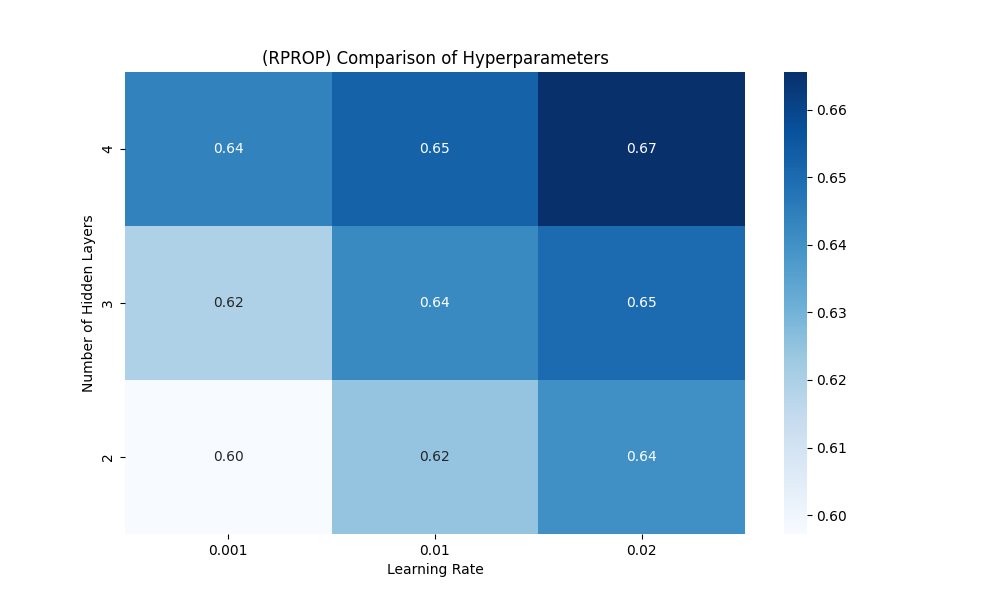
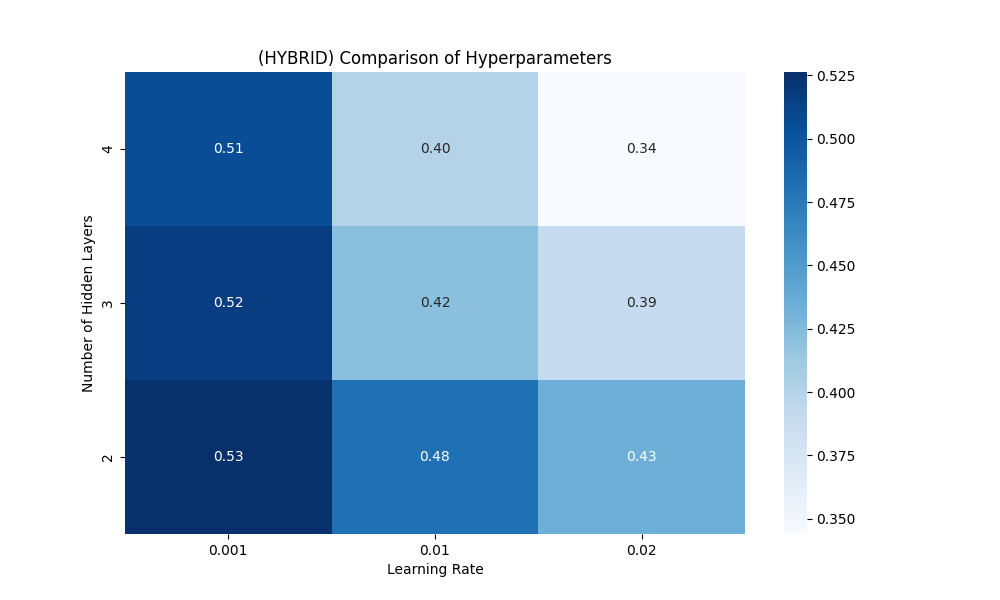
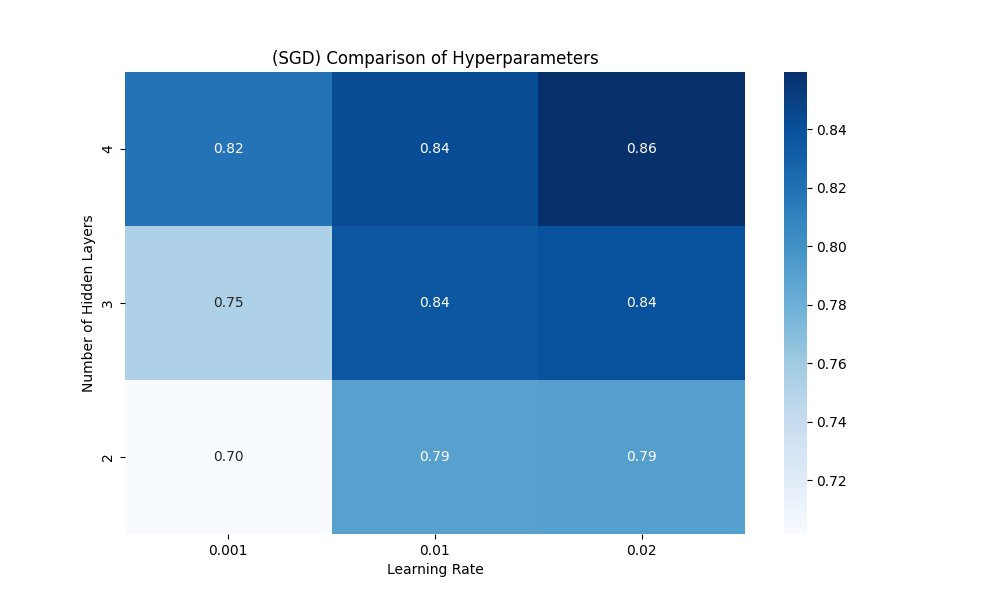

# Combined Line plots
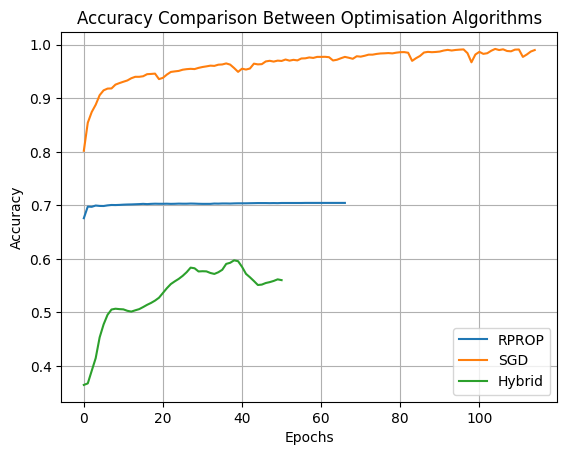
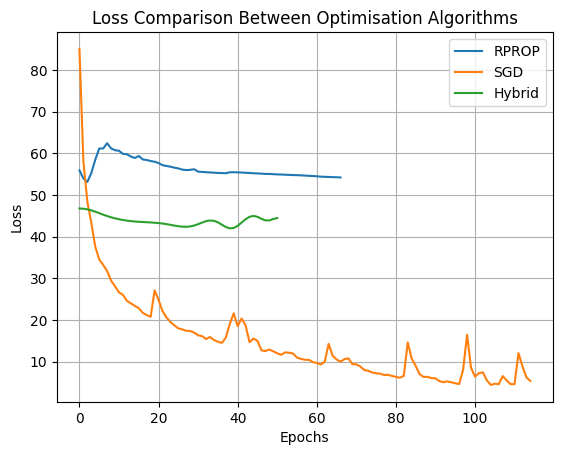